# Set up precursor plus turbines

In [1]:
# Note: this python notebook was automatically generated by make_tutorial3.py

# Load the amrwind-frontend module
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'  # Location of amrwind-frontend 
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
with open(amrwindfedir+"/turbines/IEA15MW.yaml")as f: print(f.read())

turbines:
  IEA15MW_Joukowski:     # This is an arbitrary, unique name
    turbinetype_name:    "IEA15MW_Joukowsky"
    turbinetype_comment: "Dummy layout"   # arbitrary
    Actuator_type:                JoukowskyDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150     # Double-check
    Actuator_output_frequency:    10                   
    # --------------------
    Actuator_diameters_to_sample: 5.0     # How far upstream to sample inflow wind
    #Actuator_epsilon:             [5.0]   # Epsilon in Z (might need to play with this guy)
    Actuator_num_points_r:        40      # number of radial (might need to play with this guy)
    Actuator_num_points_t:        5       # number of pts in theta (might need to play with this guy)
    #Actuator_vortex_core_size:    24.0    # might need to play with this
    # --------------------
    # These will come from
    # https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/performance/performance_ccblade.dat


In [3]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [4]:
#inputfile='../../precursor/precursor3_6x6_small_dirchange/Neutral_9mps_precursor3.inp'
inputfile='/ascldap/users/lcheung/GPFS/2022/HFM_Q4/precursor/precursor3_6x6_small_dirchange_restart/Neutral_9mps_precursor3_restart.inp'
case.loadAMRWindInput(inputfile)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('xlo.tke', '0'), ('ylo.tke', '0')])

## Set up turbine locations

In [5]:
# Set the initial yaw for each turbine
turbineyaw = 200.0

# Original turbine locations
turbxy=[
    [-169.7056275, -1527.350647],
    [-848.5281374, -848.5281374],
    [-1527.350647, -169.7056275],
    [339.411255, -339.411255],
    [-339.411255, 339.411255],
    [1527.350647, 169.7056275],
    [848.5281374, 848.5281374],
    [169.7056275, 1527.350647],
]
turboffset=[-500,-500]
farmturb_xy = [np.array(xy)+np.array(turboffset) for xy in turbxy]

In [6]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_Joukowsky, %.2f, ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turbineyaw)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
print(case.getAMRWindInput('turbines_csvtextbox'))


# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T00, -669.705627, -2027.350647, IEA15MW_Joukowsky, 200.00, ,
T01, -1348.528137, -1348.528137, IEA15MW_Joukowsky, 200.00, ,
T02, -2027.350647, -669.705627, IEA15MW_Joukowsky, 200.00, ,
T03, -160.588745, -839.411255, IEA15MW_Joukowsky, 200.00, ,
T04, -839.411255, -160.588745, IEA15MW_Joukowsky, 200.00, ,
T05, 1027.350647, -330.294373, IEA15MW_Joukowsky, 200.00, ,
T06, 348.528137, 348.528137, IEA15MW_Joukowsky, 200.00, ,
T07, -330.294373, 1027.350647, IEA15MW_Joukowsky, 200.00, ,



In [7]:
case.setAMRWindInput('turbines_createnewdomain', False)

```python
# Farm properties
farm_domainsize  = [6400.0, 6400.0, 1920.0]   # Farm domain size
farm_center      = [0, 0]
farm_background_mesh = 10.0                     # Background mesh size [meters]

# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0,0], forcechange=True)
```

In [8]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07']


In [9]:
# Input file name
inputfile = 'Neutral_9mps_smalldomain_turbine_1.inp'

# Set some globals
eps         = 5.0
vortex_core = 24.0

## make sure to add Actuator to incflo.physics
#newphysics=case.getAMRWindInput('incflo.physics') + ['Actuator']
#case.setAMRWindInput('incflo.physics', newphysics)
case.setAMRWindInput('Actuator_default_type', ['JoukowskyDisk'])
case.setAMRWindInput('Actuator_JoukowskyDisk_epsilon',       [eps], forcechange=True)  # You can change this
case.setAMRWindInput('Actuator_JoukowskyDisk_vortex_core_size', vortex_core, forcechange=True)  # You can change this

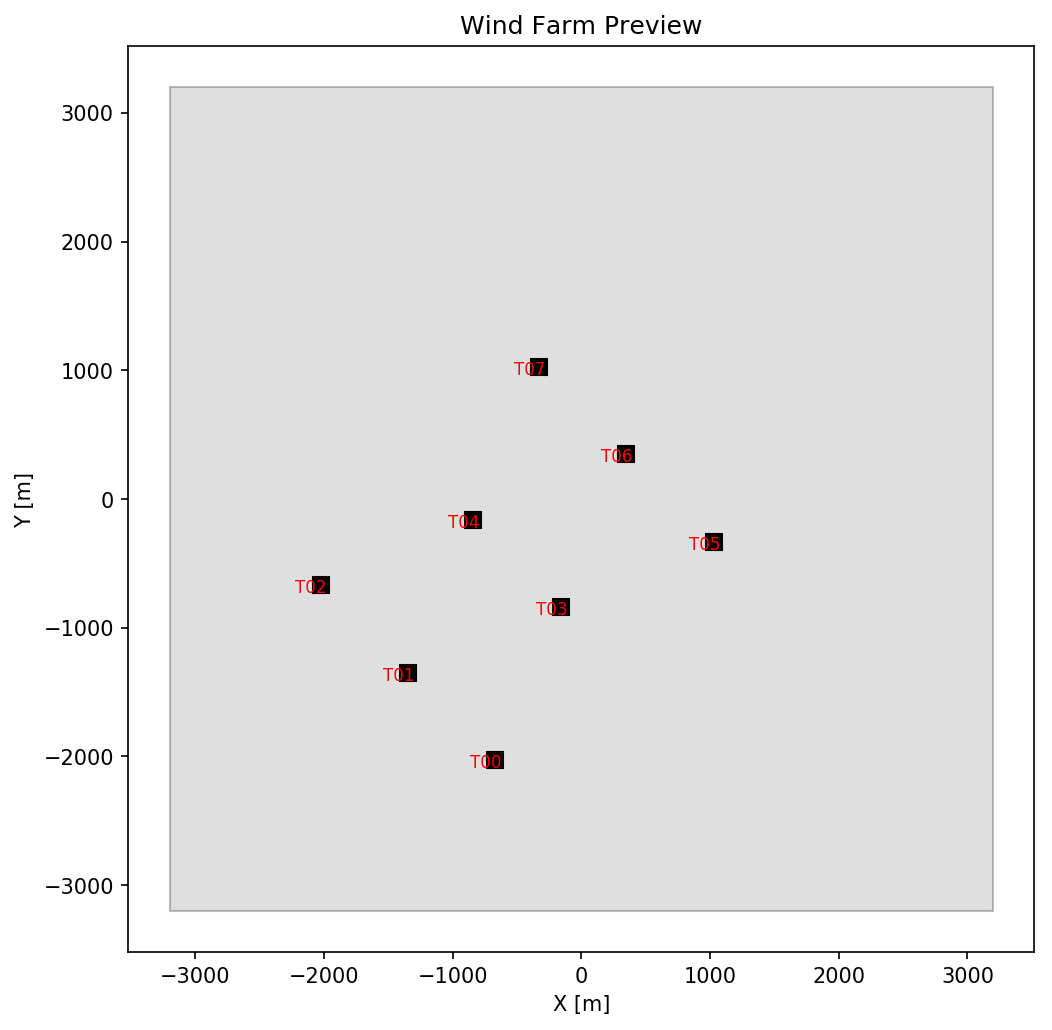

In [10]:
## Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [11]:
case.setAMRWindInput('sampling.output_frequency', 4)

## Create refinement windows

In [12]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     1.25,     1.25,       1.25, 0.525, 0.525, orientation:y
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [13]:
case.refine_createAllZones()
# Print out existing list of zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['T00_level_0_zone', 'T01_level_0_zone', 'T02_level_0_zone', 'T03_level_0_zone', 'T04_level_0_zone', 'T05_level_0_zone', 'T06_level_0_zone', 'T07_level_0_zone']


Plotting turbines


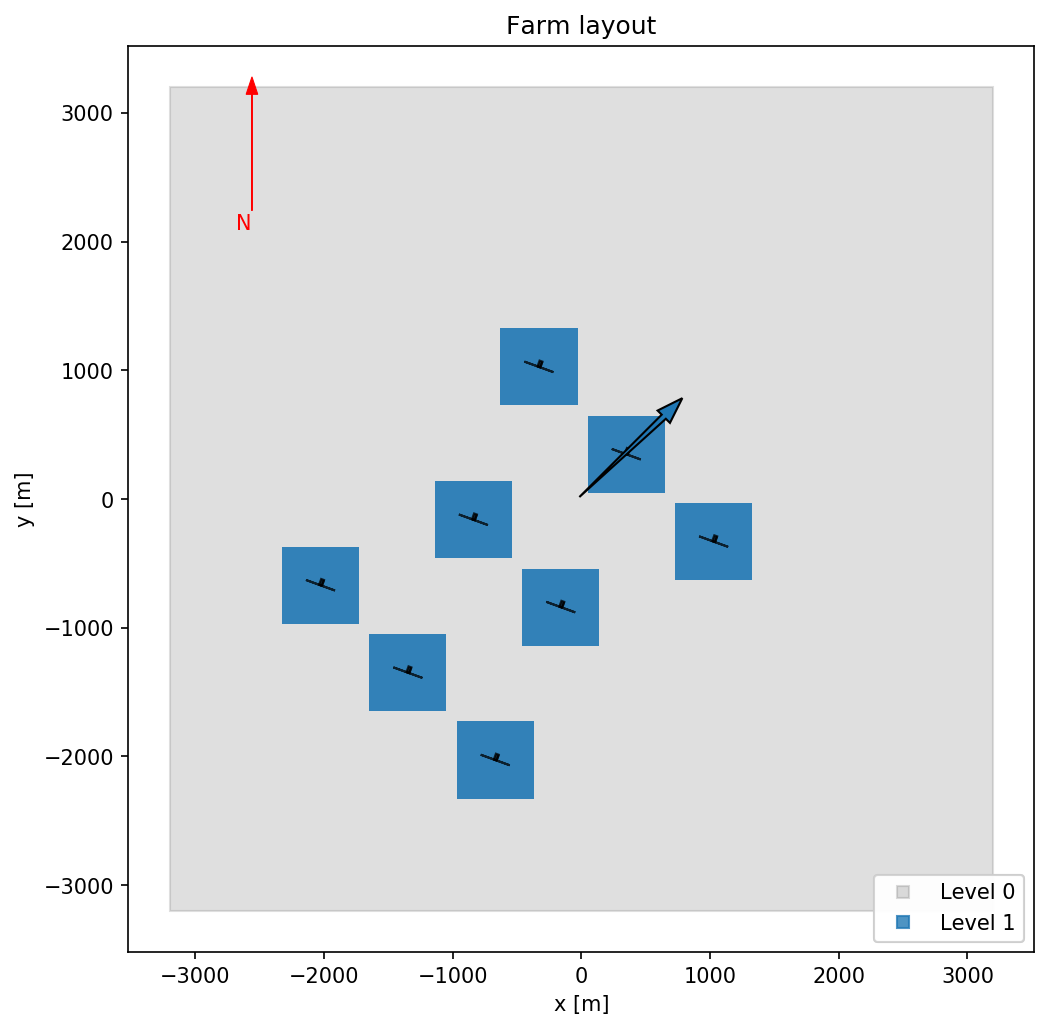

In [14]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = True
case.plotDomain(ax=ax)
ax.axis('scaled')
#ax.set_xlim([-10000,10000])
#ax.set_ylim([-10000,10000])
ax.set_title('Farm layout')

## Plot sampling planes

In [15]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
turbhh, hubheight, 1000, 1000, 750, 0, 0, 11, 11, usedx:25 units:meter orientation:y
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
#hh,  hubheight,400,400,400, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [16]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['p_hub', 'T00_turbhh', 'T01_turbhh', 'T02_turbhh', 'T03_turbhh', 'T04_turbhh', 'T05_turbhh', 'T06_turbhh', 'T07_turbhh']


Plotting turbines


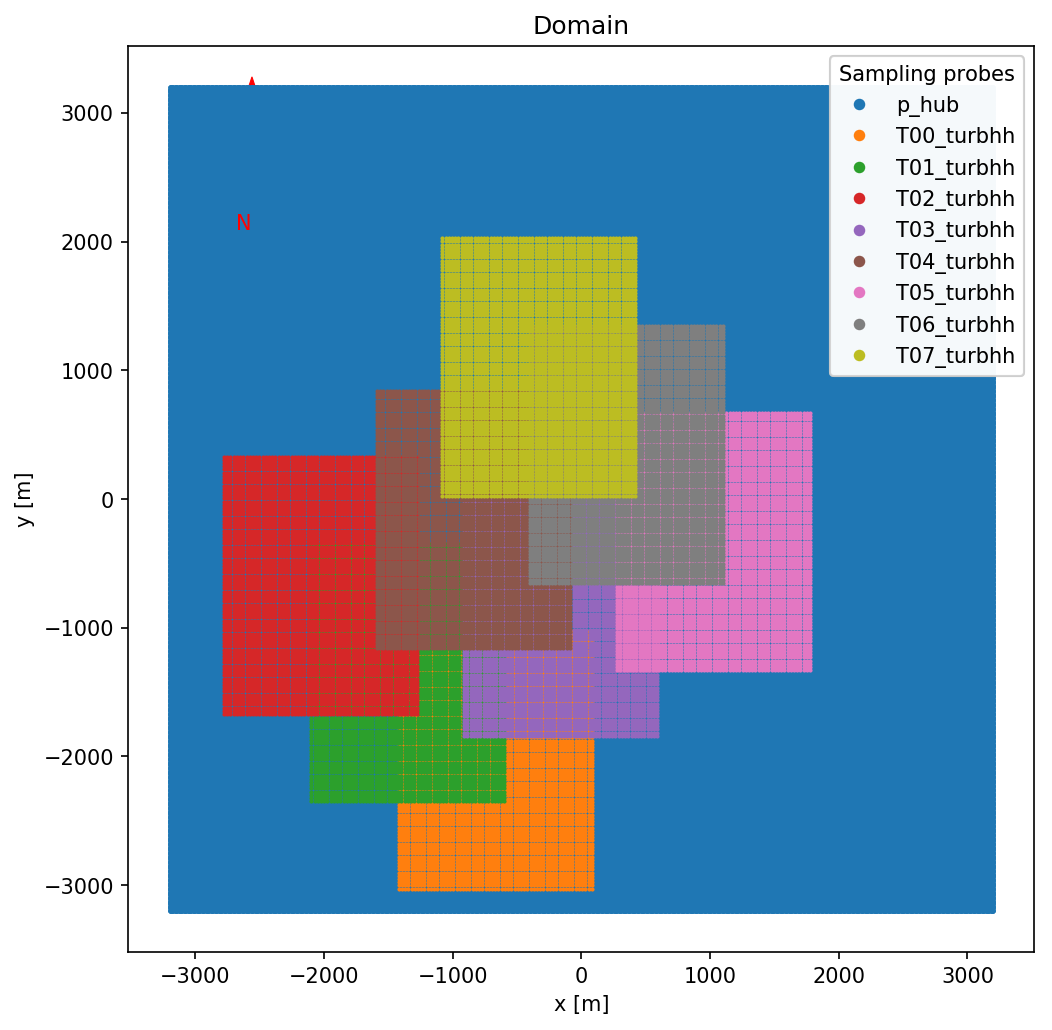

In [17]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_refineboxes']  = [] 
case.popup_storteddata['plotdomain']['plot_sampleprobes'] = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.plotDomain(ax=ax)

In [18]:
# Estimate mesh size
case.estimateMeshSize()

Refinement T00_level_0_zone: level 1: 725760 cells
Refinement T01_level_0_zone: level 1: 725760 cells
Refinement T02_level_0_zone: level 1: 725760 cells
Refinement T03_level_0_zone: level 1: 725760 cells
Refinement T04_level_0_zone: level 1: 725760 cells
Refinement T05_level_0_zone: level 1: 725760 cells
Refinement T06_level_0_zone: level 1: 725760 cells
Refinement T07_level_0_zone: level 1: 725760 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     78643200             10.0 x 10.0 x 10.0
       1      5806080                5.0 x 5.0 x 5.0
  TOTAL:     84449280


In [19]:
#case.setAMRWindInput('ABLForcing', True)
#case.setAMRWindInput('ABL.reference_temperature', 300, forcechange=True)
#case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 314.4)
#case.setAMRWindInput('ABLForcing', False, updatectrlelem=False)

In [20]:
print(case.writeAMRWindInput(inputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 26500.0             # Max (simulated) time to evolve [s]
time.max_step                            = 120000              
time.fixed_dt                            = 0.25                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = chk80000/           
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
incflo.diffusion_type                    = 1                   # Type of diffusion scheme used.  0 = explicit diffusion, 1 = Crank-Nicolson, 2 = fully implicit